# Image Classification with Convolutional Neural Networks
Steps:

1.   Explore the Data of bikes and no bikes
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy or F1-score

## Preliminaries

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr  6 12:37:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


### Libraries 

In [4]:
# Importing necessary libraries
import pathlib
import os
import random
import glob

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *


from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from skimage import io
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.feature import canny
from skimage.morphology import selem
from skimage import transform


from PIL import Image

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import itertools

import numpy as np
import pandas as pd
import cv2

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Functions

In [5]:
def plot_image(images, captions=None, cmap=None ):
    '''
    function to plot n images using subplots
    '''
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

#----------------------------------------------------------------------------------------

def ConvertImages_to_JPG(path):
    '''
    change the image format to jpg
    '''
    names = []
    for file in os.listdir(path):
        if (file.endswith('.png') or file.endswith('.bmp') or file.endswith('.gif')):
            names.append(file)
    
    for i in range(len(names)):
        im_dir = os.path.join(path, names[i])
        im = Image.open(im_dir)
        rgb_im = im.convert('RGB')
        rgb_im.save(path + 'rgb_' + str(i) + '.jpg', "JPEG")

    for i in range(len(names)):
        im_remove = os.path.join(path, names[i])
        os.remove(im_remove)

#---------------------------------------------------------------------------------------------

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1) * y_pred.argmax(axis=1), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1), 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true.argmax(axis=1) * y_pred.argmax(axis=1), 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred.argmax(axis=1), 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    recall = recall_m(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

#-----------------------------------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


#---------------------------------------------------------------------------------------------------------

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b, cmap='gray'), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Configure Environment

### Drive mount

In [6]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


###Cambio de formato png a jpeg

In [ ]:
#Convierte Imagener a jpg desde directorio de origen
path_images = "/drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike/"

dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class_ = os.path.join(dir_, clase)
        ConvertImages_to_JPG(dir_class_)

### Get Data and Create Directory

In [7]:
%rm -r /tmp/*

!cp -r /drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike /tmp

### Define each of these directories.

In [8]:
base_dir = '/tmp/data_bike'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_bikes_dir = os.path.join(train_dir, 'bike')
train_nobikes_dir = os.path.join(train_dir, 'no_bike')

# Directory with our validation cat/dog pictures
validation_bikes_dir = os.path.join(validation_dir, 'bike')
validation_nobikes_dir = os.path.join(validation_dir, 'no_bike')

# Directory with our validation cat/dog pictures
test_bikes_dir = os.path.join(test_dir, 'bike')
test_nobikes_dir = os.path.join(test_dir, 'no_bike')

### Filenames look like in the `bikes` and `no_bikes` `train` directories.

In [9]:
# Filenames look like in the bikes and no_bikes train directories.
train_bikes_fnames = os.listdir(train_bikes_dir)
train_nobikes_fnames = os.listdir(train_nobikes_dir)

print(train_bikes_fnames[:5])
print(train_nobikes_fnames[:5])

['bicicleta (111).jpeg', 'bicicleta (20).jpeg', 'bicicleta_2 (447).jpg', 'bicicleta (347).jpg', 'bicicleta (86).jpg']
['00426.jpg', 'automobile-4384810__480.jpg', '01105.jpg', '01103.jpg', 'winter-2522720__480.jpg']


### Total number of bikes and no bikes images in the `train` and `validation` directories.

In [10]:
print('total training bikes images :', len(os.listdir(train_bikes_dir)))
print('total training no_bikes images :', len(os.listdir(train_nobikes_dir)))

print('total validation bikes images :', len(os.listdir(validation_bikes_dir)))
print('total validation no_bikes images :', len(os.listdir(validation_nobikes_dir)))

print('total test bikes images :', len(os.listdir(test_bikes_dir)))
print('total test no_bikes images :', len(os.listdir(test_nobikes_dir)))

total training bikes images : 2839
total training no_bikes images : 2920
total validation bikes images : 604
total validation no_bikes images : 824
total test bikes images : 470
total test no_bikes images : 424


### Look at a few pictures.

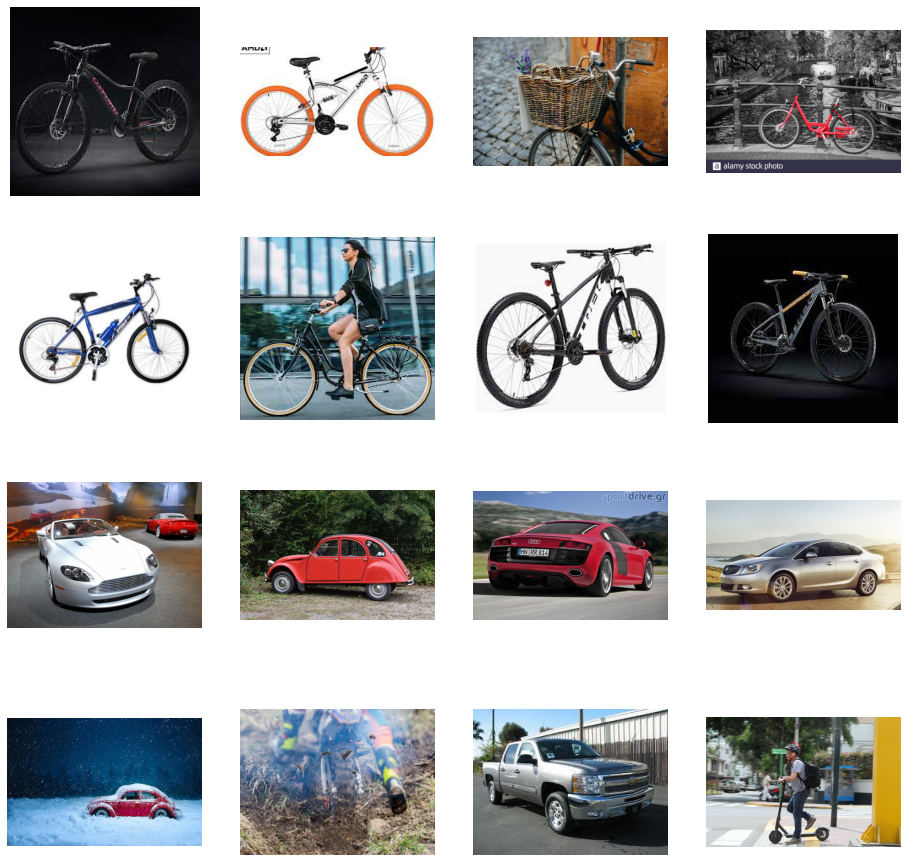

In [11]:
nrows = 4
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_bike_pix = [os.path.join(train_bikes_dir, fname) 
                for fname in train_bikes_fnames[ pic_index-8:pic_index] 
               ]

next_nobike_pix = [os.path.join(train_nobikes_dir, fname) 
                for fname in train_nobikes_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bike_pix + next_nobike_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Distribución de formatos disponibles

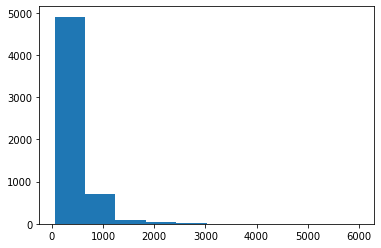

Tamaño imagenes: 290 x 400


In [12]:
path_images = "/tmp/data_bike"

dir_folders = ['train']
class_ = ['bike', 'no_bike']

formatos = []

#Busqueda del ancho y alto mas chico
for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          formatos.append(img.shape)

import pandas as pd
formatos = pd.DataFrame(formatos, columns=['Alto', 'Ancho', 'Colores'])

formatos['Tamaño_imagen'] = formatos['Alto'].astype(str) + '-' + formatos['Ancho'].astype(str)
formatos.head()

min_ancho = np.percentile(formatos['Ancho'],25).astype('int32')
min_alto = np.percentile(formatos['Alto'],25).astype('int32')

plt.hist(formatos['Alto'])
plt.show()

print('Tamaño imagenes: {} x {}'.format(min_alto, min_ancho))


In [13]:
formatos.describe()

Alto        Ancho  Colores
count  5759.000000  5759.000000   5759.0
mean    472.813683   660.455114      3.0
std     345.165686   471.061066      0.0
min      53.000000    85.000000      3.0
25%     290.500000   400.000000      3.0
50%     408.000000   612.000000      3.0
75%     480.000000   720.000000      3.0
max    6000.000000  6720.000000      3.0

## Data Preprocessing

In [14]:
from scipy.ndimage import maximum_filter, minimum_filter
from skimage import io, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt


path_images = "/tmp/data_bike"

dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

#Aplicacion de redimensionamiento y lectura en gray color

images = []

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          dir_img = os.path.join(dir_class,filename)
          img = io.imread(dir_img, as_gray=True)
          img_resized = resize(img, (min_alto, min_ancho), anti_aliasing=True)
          #sobel_img = sobel(img)  
          images.append(img_resized)
          plt.imsave(os.path.join(dir_class,filename),img_resized)

In [15]:
#Aplicacion de Filtro
images = []

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          dir_img = os.path.join(dir_class,filename)
          img = io.imread(dir_img, as_gray=True)
          sobel_img = sobel(img)  
          images.append(sobel_img)
          plt.imsave(os.path.join(dir_class,filename),sobel_img)


Ejemplo de imagen preprocesada:



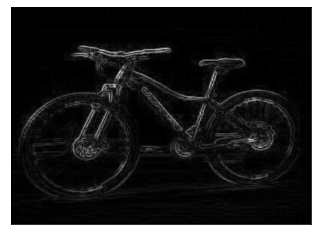


Ejemplo de imagen preprocesada:



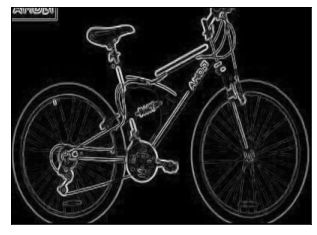


Ejemplo de imagen preprocesada:



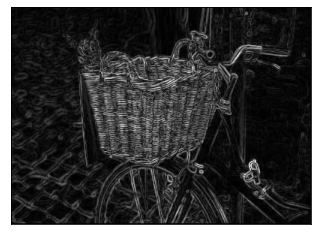


Ejemplo de imagen preprocesada:



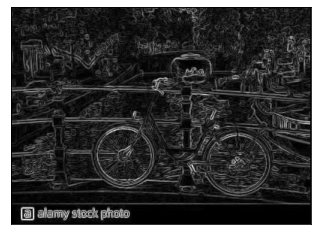


Ejemplo de imagen preprocesada:



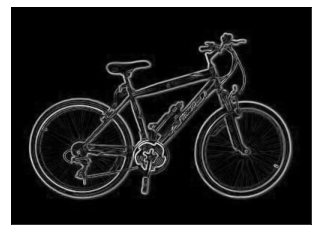

In [16]:
for i in range(5):
  fig = plt.imshow(images[i], cmap='gray')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  print('\nEjemplo de imagen preprocesada:\n')
  plt.show()

In [ ]:
images[0].mean()

##### preprocessing with SKimage

In [ ]:
#Carga de imagen as gray scale
img2 = io.imread(os.path.join(train_bikes_dir,'bicicleta_2 (853).jpg') , as_gray=True)
plt.imshow(img2, cmap='gray')

In [ ]:
#Aplicacion deconvolucion:

#Image deconvolution
#Uses deconvolution to sharpen images. 

from skimage import io, color, restoration, img_as_float


#PSF
import scipy.stats as st
import numpy as np

def gkern(kernlen=21, nsig=2):    #Returns a 2D Gaussian kernel.

    lim = kernlen//2 + (kernlen % 2)/2
    x = np.linspace(-lim, lim, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

psf = gkern(5,3)   #Kernel length and sigma

deconvolved, _ = restoration.unsupervised_wiener(img2, psf)
plt.imshow(deconvolved, cmap = 'gray')

In [ ]:
#Aplicacion de filtros para deteccion de bordes

from skimage.filters import roberts, sobel, scharr, prewitt

plt.imshow(roberts(img2), cmap = 'gray')
plt.show()
plt.imshow(sobel(img2), cmap = 'gray')
plt.show()
plt.imshow(scharr(img2), cmap = 'gray')
plt.show()
plt.imshow(prewitt(img2), cmap = 'gray')
plt.show()

In [ ]:
##Another edge filter is Canny. This is not just a single operation
#It does noise reduction, gradient calculation, and edge tracking among other things. 
#Canny creates a binary file, true or false pixels. 
plt.imshow(feature.canny(img2, sigma=1.5), cmap='gray')

In [ ]:
#Uso de opencv2



'''
def midpoint(img):
    maxf = maximum_filter(img, (3, 3))
    minf = minimum_filter(img, (3, 3))
    midpoint = (maxf + minf) / 2
    #cv2_imshow(midpoint)

def contraharmonic_mean(img, size, Q):
    num = np.power(img, Q + 1)
    denom = np.power(img, Q)
    kernel = np.full(size, 1.0)
    result = cv2.filter2D(num, -1, kernel) / cv2.filter2D(denom, -1, kernel)
    return result


for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          dir_img = os.path.join(dir_class,filename)
          img = cv2.imread(dir_img, cv2.IMREAD_GRAYSCALE)
          blur = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)
          #r, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
          #cv2_imshow(contraharmonic_mean(sp_05, (3,3), 0.5))
          #mid_point = midpoint(threshold)
          images.append(blur)
          cv2.imwrite(os.path.join(dir_class,filename),blur)'''

### ImageDataGenerator

#### ImageDataGenerator for Train

In [17]:
# ImageDataGenerator for train data
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (min_alto, min_ancho),
                                                                              batch_size = 16,
                                                                              shuffle=True,
                                                                              color_mode="grayscale",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)


Found 5759 images belonging to 2 classes.


Some Images:



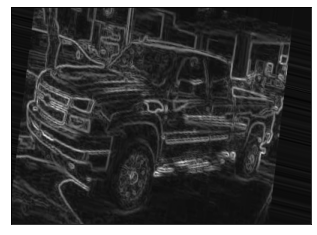

(290, 400, 1)
Clase: 1.0


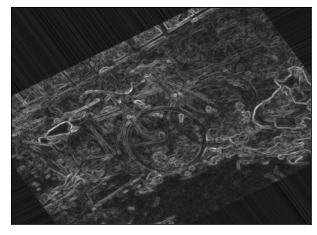

(290, 400, 1)
Clase: 0.0


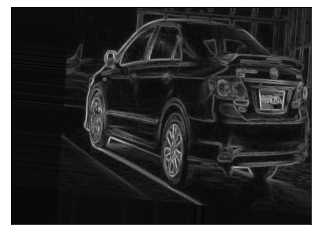

(290, 400, 1)
Clase: 1.0


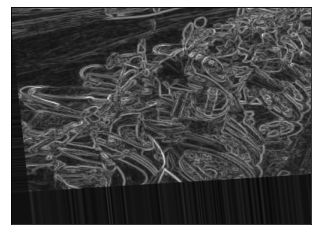

(290, 400, 1)
Clase: 1.0


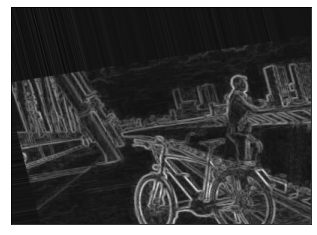

(290, 400, 1)
Clase: 0.0


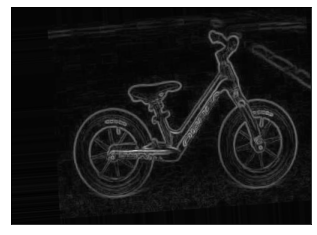

(290, 400, 1)
Clase: 0.0


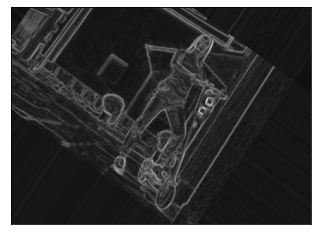

(290, 400, 1)
Clase: 1.0


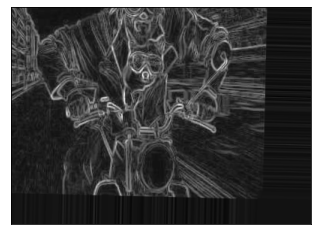

(290, 400, 1)
Clase: 1.0


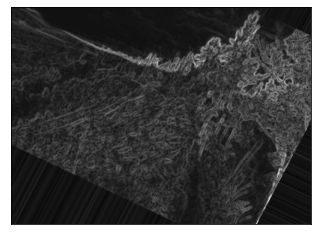

(290, 400, 1)
Clase: 0.0


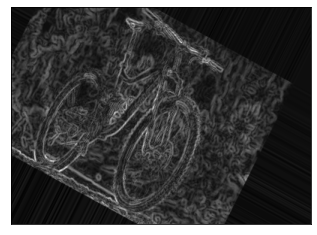

(290, 400, 1)
Clase: 0.0


In [18]:
X_train, y_train = next(train_generator)                                  

print('Some Images:\n')
for i in range(10):
  
  if X_train[i].shape[2] == 1:
    image1 = X_train[i][:, :, 0]
  fig = plt.imshow(image1, cmap='gray')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.show()
  print(X_train[i].shape)
  print('Clase: {}'.format(y_train[i][1]))

In [ ]:
X_train[0].mean()

#### ImageDataGenerator for Validation and Test

In [19]:
# ImageDataGenerator for validation data
val_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(validation_dir,
                                                                            target_size = (min_alto, min_ancho),
                                                                            batch_size = 16,
                                                                            shuffle=True,
                                                                            color_mode="grayscale",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)

X_val, y_val = next(val_generator)                                  

print('-- Image Dimensions --', X_val[0].shape)                                                                        

Found 1428 images belonging to 2 classes.
-- Image Dimensions -- (290, 400, 1)


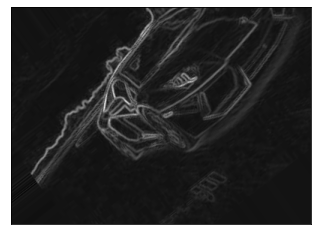

(290, 400, 1)
Clase: 1.0


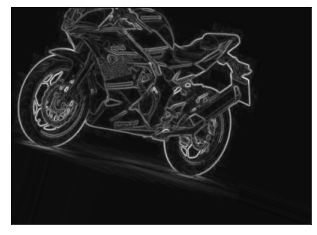

(290, 400, 1)
Clase: 1.0


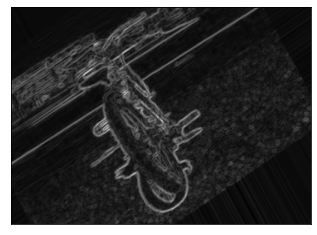

(290, 400, 1)
Clase: 0.0


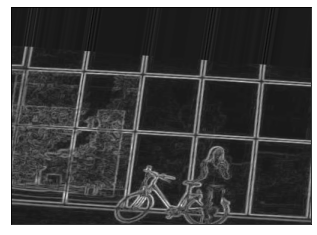

(290, 400, 1)
Clase: 0.0


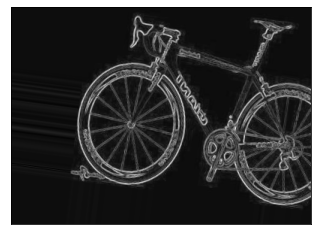

(290, 400, 1)
Clase: 0.0


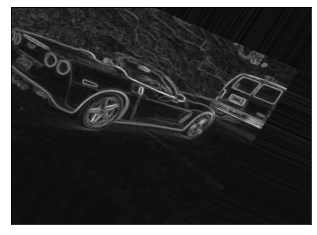

(290, 400, 1)
Clase: 1.0


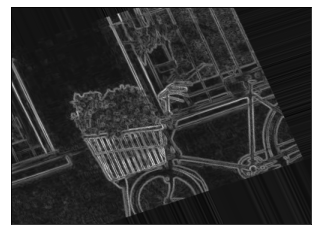

(290, 400, 1)
Clase: 0.0


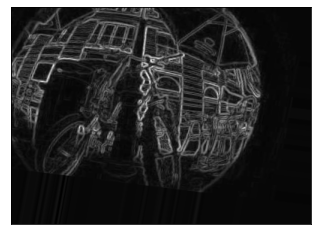

(290, 400, 1)
Clase: 0.0


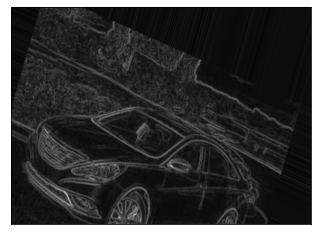

(290, 400, 1)
Clase: 1.0


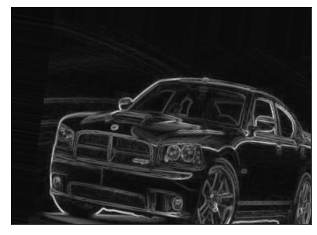

(290, 400, 1)
Clase: 1.0


In [20]:
for i in range(10):
  
  if X_val[i].shape[2] == 1:
    image1 = X_val[i][:, :, 0]
  fig = plt.imshow(image1, cmap='gray')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.show()
  print(X_val[i].shape)
  print('Clase: {}'.format(y_val[i][1]))

Found 894 images belonging to 2 classes.
-- Image Dimensions -- (290, 400, 1)


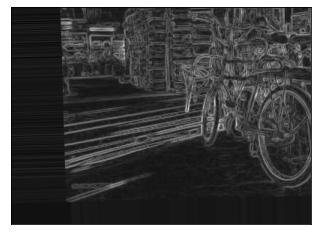

(290, 400, 1)
Clase: 0.0


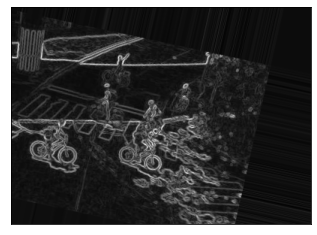

(290, 400, 1)
Clase: 0.0


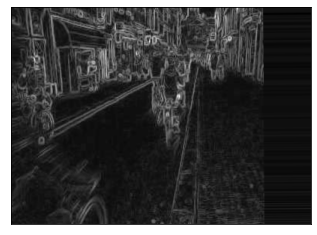

(290, 400, 1)
Clase: 0.0


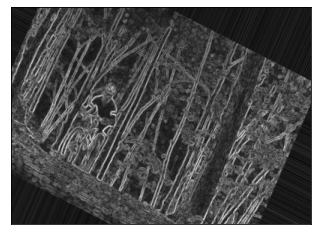

(290, 400, 1)
Clase: 0.0


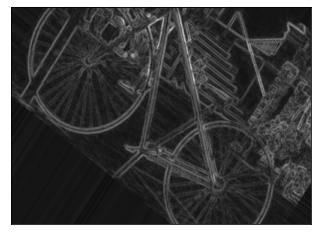

(290, 400, 1)
Clase: 0.0


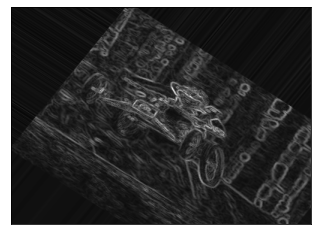

(290, 400, 1)
Clase: 0.0


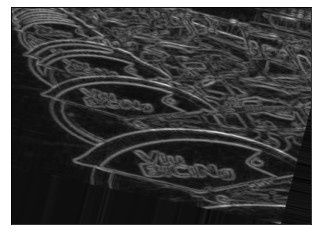

(290, 400, 1)
Clase: 0.0


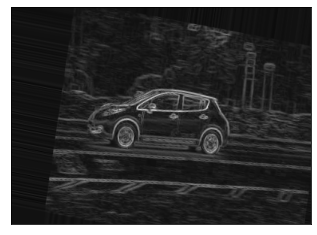

(290, 400, 1)
Clase: 1.0


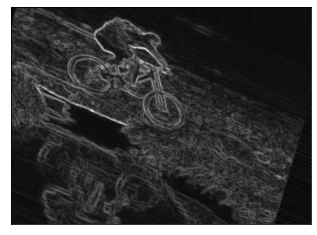

(290, 400, 1)
Clase: 0.0


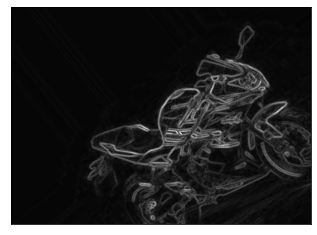

(290, 400, 1)
Clase: 1.0


In [21]:
# ImageDataGenerator for test data
test_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(test_dir,
                                                                            target_size = (min_alto, min_ancho),
                                                                            batch_size = 1000,
                                                                            shuffle=True,
                                                                            color_mode="grayscale",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)  
                                                                          
X_test, y_test = next(test_generator)                                  

print('-- Image Dimensions --', X_test[0].shape)
for i in range(10):
  
  if X_test[i].shape[2] == 1:
    image1 = X_test[i][:, :, 0]
  fig = plt.imshow(image1, cmap='gray')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.show()
  print(X_test[i].shape)
  print('Clase: {}'.format(y_test[i][1]))

## Modelling ConvNet

### Model Architecture

In [22]:
# Build the model using the functional API
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2))(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
#x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(4096, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(i, x)

### Summary of the Model

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 290, 400, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 290, 400, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 290, 400, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 290, 400, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 145, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 200, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 145, 200, 32)      9248  

### Compile and Fit Model

In [24]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc', 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [25]:
# Class for callback
class myCallback(tf.keras.callbacks.Callback):
    
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('acc') > accuracy_threshold):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(accuracy_threshold*100))
			self.model.stop_training = True

In [26]:
# Fit
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

# Threshold for early stopping
accuracy_threshold = 0.98

# Instantiate a callback object
callbacks = myCallback()

r = model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid,
              callbacks=[callbacks],
              epochs=300, 
              verbose=2)

Epoch 1/300
359/359 - 97s - loss: 0.7732 - acc: 0.5939 - precision: 0.5939 - recall: 0.5939 - val_loss: 0.7811 - val_acc: 0.4221 - val_precision: 0.4221 - val_recall: 0.4221
Epoch 2/300
359/359 - 78s - loss: 0.6051 - acc: 0.6855 - precision: 0.6855 - recall: 0.6855 - val_loss: 0.5806 - val_acc: 0.7177 - val_precision: 0.7177 - val_recall: 0.7177
Epoch 3/300
359/359 - 78s - loss: 0.5527 - acc: 0.7221 - precision: 0.7221 - recall: 0.7221 - val_loss: 0.7782 - val_acc: 0.6166 - val_precision: 0.6166 - val_recall: 0.6166
Epoch 4/300
359/359 - 78s - loss: 0.5030 - acc: 0.7470 - precision: 0.7470 - recall: 0.7470 - val_loss: 0.6256 - val_acc: 0.6664 - val_precision: 0.6664 - val_recall: 0.6664
Epoch 5/300
359/359 - 78s - loss: 0.4946 - acc: 0.7569 - precision: 0.7569 - recall: 0.7569 - val_loss: 0.6821 - val_acc: 0.6180 - val_precision: 0.6180 - val_recall: 0.6180
Epoch 6/300
359/359 - 78s - loss: 0.4553 - acc: 0.7754 - precision: 0.7754 - recall: 0.7754 - val_loss: 0.5289 - val_acc: 0.7261 -

In [51]:
model.save('bike_class_sobel.h5')

### Evaluate Model

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

from sklearn.metrics import classification_report

##### Performance Training

In [28]:
# ImageDataGenerator for train data
train_performance = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (min_alto, min_ancho),
                                                                              batch_size = 6000,
                                                                              shuffle=True,
                                                                              color_mode="grayscale",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)

Found 5759 images belonging to 2 classes.


Some Images:



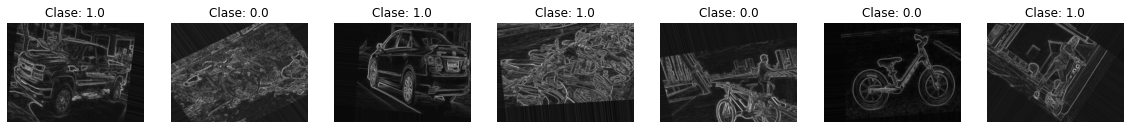

In [29]:
images_train, images_class = next(train_performance)

%matplotlib inline
axoff_fun = np.vectorize(lambda axs:axs.axis('off'))

print('Some Images:\n')
fig, axs = plt.subplots(nrows=1, ncols= 7, figsize= (20,10))
axoff_fun(axs)
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if images_train[i].shape[2] == 1:
      image_plot = images_train[i][:, :, 0]

    plt.imshow(image_plot, cmap='gray')
    #plt.colorbar()
    plt.title('Clase: {}'.format(images_class[i][1]))


Confusion matrix, without normalization
[[2824   15]
 [  91 2829]]


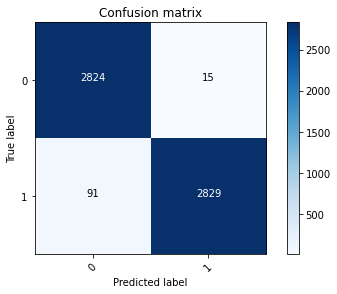

In [30]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [31]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2839
           1       0.99      0.97      0.98      2920

    accuracy                           0.98      5759
   macro avg       0.98      0.98      0.98      5759
weighted avg       0.98      0.98      0.98      5759



#### Plot loss per iteration training

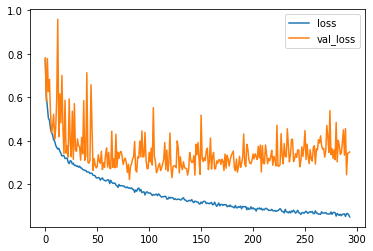

In [32]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

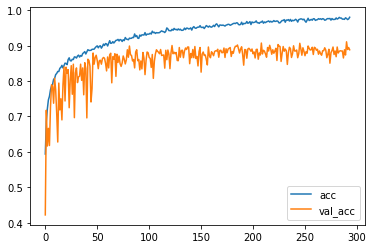

In [33]:
# Plot accuracy per iteration
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend();

#### Performance en validacion

In [34]:
# ImageDataGenerator for train data
val_performance = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(validation_dir,
                                                                              target_size = (min_alto, min_ancho),
                                                                              batch_size = 6000,
                                                                              shuffle=True,
                                                                              color_mode="grayscale",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)
                                     
images_train, images_class = next(val_performance)

Found 1428 images belonging to 2 classes.


Some Images:



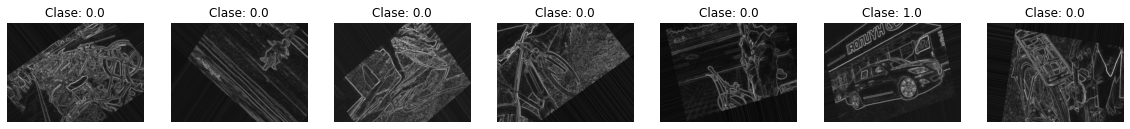

In [37]:
images_train, images_class = next(val_performance)

%matplotlib inline
axoff_fun = np.vectorize(lambda axs:axs.axis('off'))

print('Some Images:\n')
fig, axs = plt.subplots(nrows=1, ncols= 7, figsize= (20,10))
axoff_fun(axs)
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if images_train[i].shape[2] == 1:
      image_plot = images_train[i][:, :, 0]

    plt.imshow(image_plot, cmap='gray')
    #plt.colorbar()
    plt.title('Clase: {}'.format(images_class[i][1]))


Confusion matrix, without normalization
[[516  88]
 [ 70 754]]


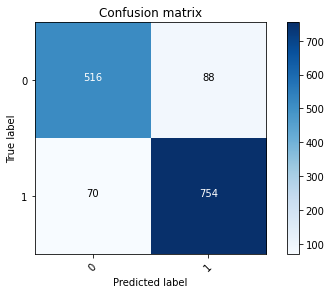

In [38]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [39]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       604
           1       0.90      0.92      0.91       824

    accuracy                           0.89      1428
   macro avg       0.89      0.88      0.89      1428
weighted avg       0.89      0.89      0.89      1428



##### Performance en testing

Some Images:



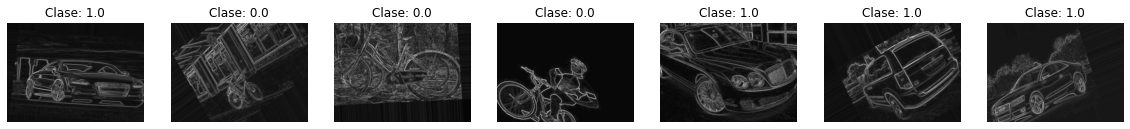

In [40]:
images_train, images_class = next(test_generator)

%matplotlib inline
axoff_fun = np.vectorize(lambda axs:axs.axis('off'))

print('Some Images:\n')
fig, axs = plt.subplots(nrows=1, ncols= 7, figsize= (20,10))
axoff_fun(axs)
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if images_train[i].shape[2] == 1:
      image_plot = images_train[i][:, :, 0]

    plt.imshow(image_plot, cmap='gray')
    #plt.colorbar()
    plt.title('Clase: {}'.format(images_class[i][1]))


Confusion matrix, without normalization
[[410  60]
 [  4 420]]


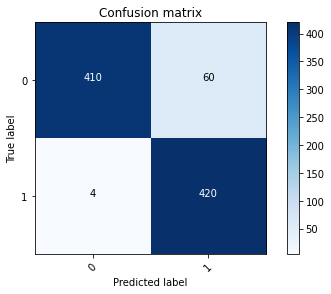

In [41]:
predict_classes = model.predict(images_train).argmax(axis=1)
original_classes = images_class.argmax(axis=1)
cm = confusion_matrix(original_classes, predict_classes)
plot_confusion_matrix(cm, list(range(2)))

In [42]:
print(classification_report(original_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       470
           1       0.88      0.99      0.93       424

    accuracy                           0.93       894
   macro avg       0.93      0.93      0.93       894
weighted avg       0.94      0.93      0.93       894



#### Concusiones

In [43]:
# label mapping
labels = '''bike
nobike'''.split()

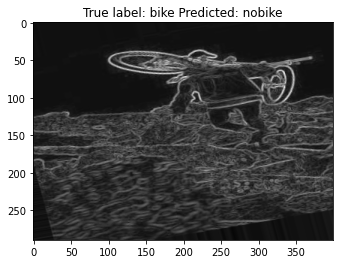

In [46]:
# Show some misclassified examples
misclassified_idx = np.where(predict_classes != original_classes)[0]
i = np.random.choice(misclassified_idx).astype(int)

if images_train[i].shape[2] == 1:
    image1 = images_train[i][:, :, 0]
plt.imshow(image1, cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[original_classes[i]], labels[predict_classes[i]]));


In [52]:
# Upload image
from google.colab import files
from shutil import copyfile
from keras.preprocessing import image
os.mkdir('/content/image/')

uploaded = files.upload()

Saving 01622.jpg to 01622.jpg
Saving 01624.jpg to 01624.jpg
Saving 828841001_1.jpg to 828841001_1.jpg
Saving bici 2.png to bici 2.png
Saving MicrosoftTeams-image (4).png to MicrosoftTeams-image (4) (1).png
Saving MicrosoftTeams-image.png to MicrosoftTeams-image (1).png
Saving Moto_Juancho 3.png to Moto_Juancho 3 (1).png
Saving Moto_juancho 4.png to Moto_juancho 4 (1).png
Saving Moto_Juancho.png to Moto_Juancho.png
Saving row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg to row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg
Saving sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg to sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg
Saving WhatsApp Image 2021-03-26 at 13.05.02.jpeg to WhatsApp Image 2021-03-26 at 13.05.02.jpeg
Saving woman-on-scooter-on-parisian-street-picture-id1128757501.jpg to woman-on-scooter-on-parisian-street-p

Nombre de la foto: 01622.jpg
(290, 400, 1)
0.18217231


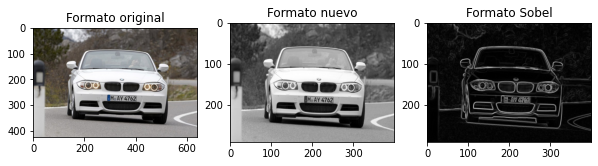

Prediction:  1
Probabilty:  2.19675e-09
01622.jpg isn't a bike
.............................................

Nombre de la foto: 01624.jpg
(290, 400, 1)
0.17039916


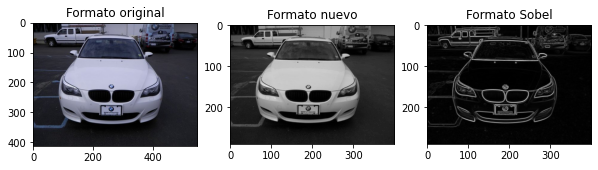

Prediction:  1
Probabilty:  2.057396e-05
01624.jpg isn't a bike
.............................................

Nombre de la foto: 828841001_1.jpg
(290, 400, 1)
0.14100467


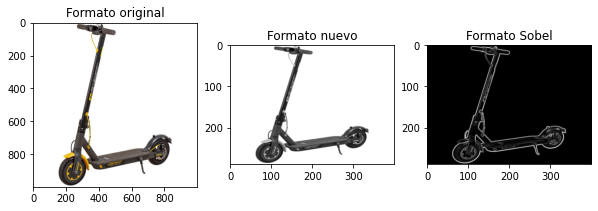

Prediction:  1
Probabilty:  4.1061455e-12
828841001_1.jpg isn't a bike
.............................................

Nombre de la foto: bici 2.png
(290, 400, 1)
0.18616475


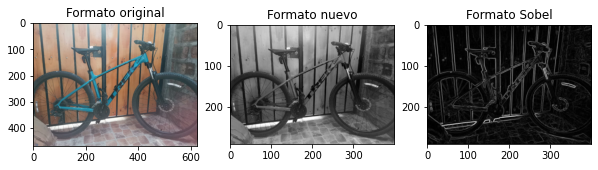

Prediction:  0
Probabilty:  0.9999999
bici 2.png is a bike
.............................................

Nombre de la foto: MicrosoftTeams-image (4).png
(290, 400, 1)
0.17869762


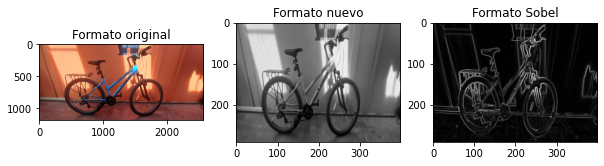

Prediction:  0
Probabilty:  0.9999989
MicrosoftTeams-image (4).png is a bike
.............................................

Nombre de la foto: MicrosoftTeams-image.png
(290, 400, 1)
0.16787285


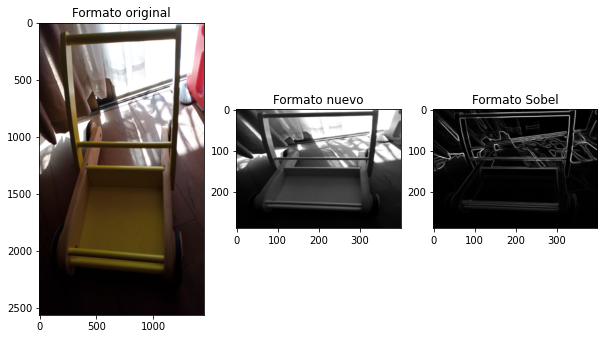

Prediction:  0
Probabilty:  0.98163754
MicrosoftTeams-image.png is a bike
.............................................

Nombre de la foto: Moto_Juancho 3.png
(290, 400, 1)
0.18659171


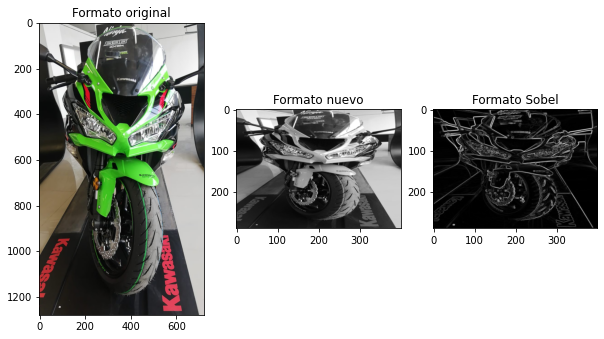

Prediction:  0
Probabilty:  0.99988294
Moto_Juancho 3.png is a bike
.............................................

Nombre de la foto: Moto_juancho 4.png
(290, 400, 1)
0.1859145


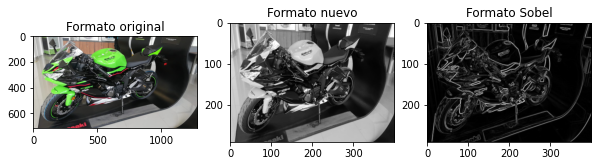

Prediction:  1
Probabilty:  0.0008275172
Moto_juancho 4.png isn't a bike
.............................................

Nombre de la foto: Moto_Juancho.png
(290, 400, 1)
0.20924366


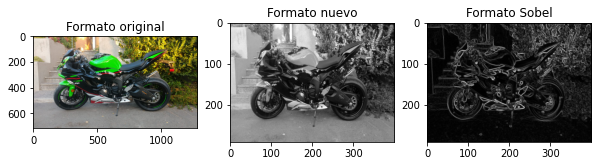

Prediction:  1
Probabilty:  1.0088361e-14
Moto_Juancho.png isn't a bike
.............................................

Nombre de la foto: row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg
(290, 400, 1)
0.19910236


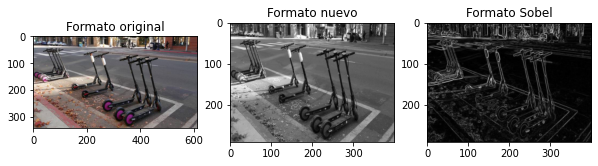

Prediction:  1
Probabilty:  1.2298481e-06
row-of-ride-sharing-electric-scooters-parked-on-street-in-gaslamp-picture-id1263556504.jpg isn't a bike
.............................................

Nombre de la foto: sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg
(290, 400, 1)
0.20816869


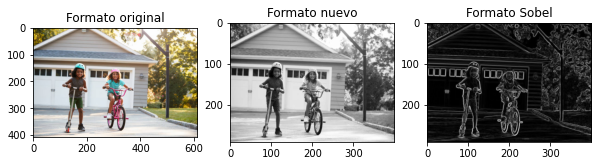

Prediction:  0
Probabilty:  0.9994103
sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg is a bike
.............................................

Nombre de la foto: WhatsApp Image 2021-03-26 at 13.05.02.jpeg
(290, 400, 1)
0.20350769


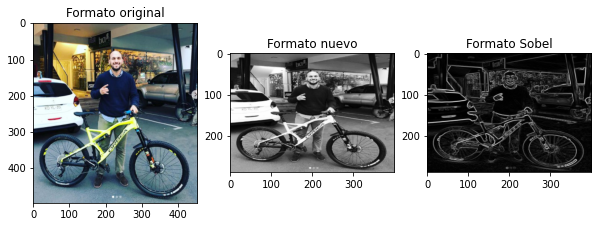

Prediction:  0
Probabilty:  1.0
WhatsApp Image 2021-03-26 at 13.05.02.jpeg is a bike
.............................................

Nombre de la foto: woman-on-scooter-on-parisian-street-picture-id1128757501.jpg
(290, 400, 1)
0.22392605


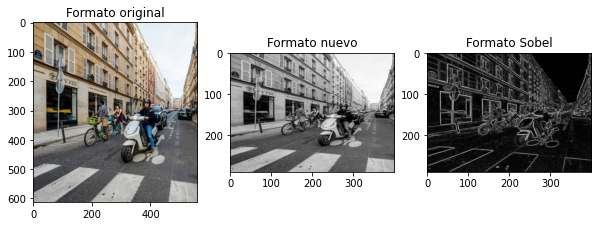

Prediction:  1
Probabilty:  1.7927274e-08
woman-on-scooter-on-parisian-street-picture-id1128757501.jpg isn't a bike
.............................................



In [55]:
# Clasiffier Image
for fn in uploaded.keys():
  print('Nombre de la foto: {}'.format(fn))
  
  path = '/content/' + fn

  new_path = '/content/image/' + fn

  orig_print = io.imread(path)
  original = io.imread(path, as_gray=True).astype(np.float32)
  img_resize = resize(original, (min_alto, min_ancho), anti_aliasing=True)
  sobel_img = sobel(img_resize)
  
  plt.imsave(new_path, sobel_img)

  final_img = tf.keras.preprocessing.image.load_img(new_path, color_mode='grayscale', target_size=(min_alto, min_ancho))
  final_img = keras.preprocessing.image.img_to_array(final_img)
  final_img = final_img / 255.
  print(final_img.shape)
  x = np.expand_dims(final_img, axis=0)
  print(x.mean())

  #print('Formato original: {}, Tipo: {}'.format(original.shape, original.dtype))
  #print('Formato nuevo: {}, Tipo: {}'.format(img_resize.shape, img_resize.dtype))
  #print('Formato Sobel: {}, Tipo: {}'.format(sobel_img.shape, sobel_img.dtype))

  f, axarr = plt.subplots(nrows=1,ncols=3, figsize= (10,10))
  plt.sca(axarr[0]); 
  plt.imshow(orig_print, cmap='gray'); plt.title('Formato original')
  plt.sca(axarr[1]); 
  plt.imshow(img_resize, cmap='gray'); plt.title('Formato nuevo')
  plt.sca(axarr[2]); 
  plt.imshow(sobel_img, cmap='gray'); plt.title('Formato Sobel')
  plt.show()

  pred = model.predict(x)
  
  classes = model.predict(x).argmax(axis=1)
  prob = model.predict(x)[0][0]
 
  print('Prediction: ', classes[0])
  print('Probabilty: ', prob)
    
  if classes[0] == 0:
    print(fn + " is a bike")
  else:
    print(fn + " isn't a bike")

  print('.............................................\n')